<!--NAVIGATION-->
< [深入：k-均值聚类](05.11-K-Means.ipynb) | [目录](Index.ipynb) | [深入：核密度估计](05.13-Kernel-Density-Estimation.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In Depth: Gaussian Mixture Models

# 深入：高斯混合模型

> The *k*-means clustering model explored in the previous section is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application.
In particular, the non-probabilistic nature of *k*-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.
In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind *k*-means, but can also be a powerful tool for estimation beyond simple clustering.

前一小节讨论的k均值聚类模型是简单和相对容易理解的，但是简单的代价就是在实际应用中会遇到挑战。具体来说，k均值的非概率本质和其简单的依据与中心点距离来划分聚类的方式，决定了在很多真实世界情况中表现很不理想。本节中我们会学习高斯混合模型，它被认为是k均值算法的一种拓展，且能作为超越简单聚类的一个强大工具。

> We begin with the standard imports:

导入包：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM: Weaknesses of k-Means

## 使用GMM：k均值的弱点

> Let's take a look at some of the weaknesses of *k*-means and think about how we might improve the cluster model.
As we saw in the previous section, given simple, well-separated data, *k*-means finds suitable clustering results.

让我们先来看一下k均值算法的弱点，然后考虑如何能够改进它。正如上一节中我们看到的，给定简单的良好分离的数据，k均值能够找到正确的聚类结果。

> For example, if we have simple blobs of data, the *k*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

例如我们有一些简单的数据群落，k均值算法能够迅速的标记这些聚类，得到的结果符合我们肉眼观测的情况：

译者注：下面代码为适应新版scikit-learn去除了`sample_generator`模块以避免产生警告。

In [2]:
# 生成数据
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

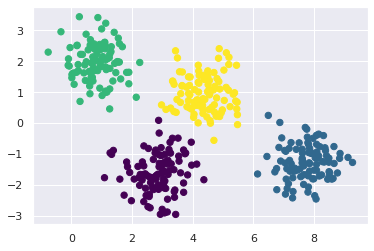

In [3]:
# 使用k均值进行聚类，并绘制结果
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

> From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them.
Unfortunately, the *k*-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
For this, we must think about generalizing the model.

直觉上来看，我们会发现图中某些数据点的聚类结果会比其他点的结果更加确定：例如图中中间两个聚类之间有很少量的重叠部分，这附近的数据点我们并不能非常确定其从属于其相应的聚类中。

> One way to think about the *k*-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.
This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
We can visualize this cluster model with the following function:

我们考虑k均值算法时，可以认为它是以中心点为圆心（球心），距离中心点最远的点的距离为半径的一个圆（或者在高维空间中是一个超球体）。这些范围被认为是训练集聚类的硬边界：任何边界外的数据点都不会被认为是属于该聚类的。通过下面的函数可以将这个想法可视化出来：

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # 绘制输入数据点
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # 绘制k均值模型
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

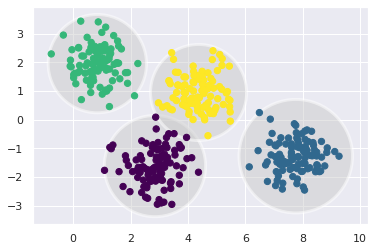

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

> An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

k均值一个重要的特点是这些聚类模型*必须是圆形*的：k均值没有內建的方式来处理长方形或者椭圆形的聚类。因此如果我们将同样的数据转换一下，聚类的结果将会变得混乱起来：

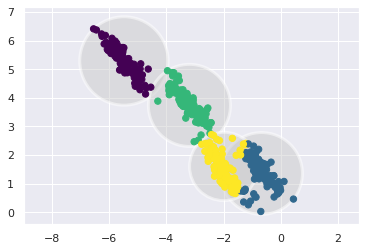

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

> By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.
Nevertheless, *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.
One might imagine addressing this particular situation by preprocessing the data with PCA (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)), but in practice there is no guarantee that such a global operation will circularize the individual data.

肉眼观察可知转换后的聚类不是圆形的，因此圆形的聚类模型会导致不理想的拟合。然而，k均值并不具有这样的灵活性，仍然按照圆形将数据点分在四个聚类当中。这样导致的结果会是圆形的大面积重合：图中右下角的部分很清晰地展示了这一点。一种可能的解决方案是使用PCA（参见[深入：主成分分析](05.09-Principal-Component-Analysis.ipynb)）对数据进行预处理，但是实践当中并不能保证这样的全局操作能对所有数据集都能产生圆形的模型聚类。

> These two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

k均值的这两个缺点，模型形状缺乏灵活性和无概率聚类本质，意味着对于很多数据集（特别是低维度数据集）来说，它可能不会按照预期那样工作。

> You might imagine addressing these weaknesses by generalizing the *k*-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.
It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

也许你会想到通过对k均值模型进行泛化来解决这些缺点：例如你可以通过对每个数据点计算其与*所有*的聚类中心点的距离来测算不确定度，而不是仅考虑最近的中心点。你也可以将聚类边界泛化成椭圆而不是圆形来适配非圆形聚类。这两个泛化技巧发展成为另外一个的聚类模型，高斯混合模型。

## Generalizing E–M: Gaussian Mixture Models

## 泛化期望最大化算法：高斯混合模型

> A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

高斯混合模型（GMM）试图在输入数据集中找到多维高斯概率混合分布模型。在最简单情况下，GMM能够像k均值一样的对数据进行聚类：

译者注：新版Scikit-Learn中，GMM已经改为GaussianMixture，下面代码相应修改。

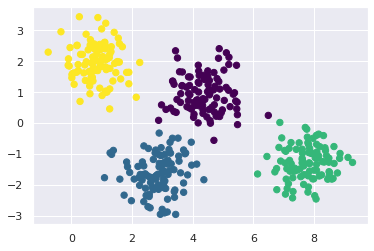

In [7]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

但是因为高斯混合模型内置了概率模型，因此能使用Scikit-Learn中的`predict_proba`方法获得聚类的概率数据。该方法会返回一个`[n_samples, n_clusters]`的数组，里面包含每个数据点从属于每个聚类的概率值：

In [8]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.531 0.    0.469 0.   ]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    1.    0.    0.   ]]


> We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

比方说我们可以将这种不确定度可视化成每个数据点的大小，越确定的面积越大；就像下图所示，在两个聚类边界附近的数据点小一些，表明不确定性更高：

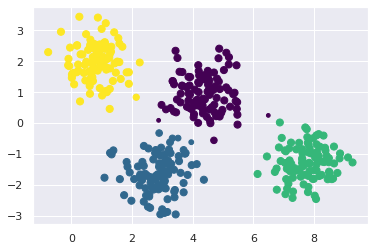

In [9]:
size = 50 * probs.max(1) ** 2  # 平方概率表示面积差别
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

> Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

> 1. Choose starting guesses for the location and shape
2. Repeat until converged:
   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights
   
底层实现上，高斯混合模型与k均值很相似：它也使用期望最大化算法，其算法步骤如下：

1. 选择初始位置和形状
2. 重复以下步骤：
    1. *E-step*：对每个数据点，找到其从属于每个聚类的概率值
    2. *M-step*：对每个聚类，依据所有从属的数据点，使用权重值计算更新它的位置，标准化值和形状

> The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

这样算法得到的结果，每个聚类不是依据硬边界的圆形来区分，而是依据平滑的高斯模型来区分。不过与k均值的期望最大化算法一样，上述算法有时也会得不到全局最优解，因此实践中也需要使用多个随机的初始值。

> Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

下面我们创建一个函数来帮助我们根据GMM输出结果来绘制聚类的位置和形状：

译者注：新版Scikit-Learn的GaussianMixture评估器中已经不再使用covar_属性了，代码中修改为covariances_。

In [10]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """根据给定的位置和协方差绘制模型椭圆"""
    ax = ax or plt.gca()
    
    # 将协方差转换为主坐标轴
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # 绘制椭圆
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

> With this in place, we can take a look at what the four-component GMM gives us for our initial data:

有了这些函数，我们可以对前面的数据集在GMM下的模型进行展示：

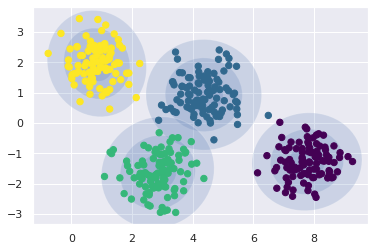

In [11]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

> Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

相应的，可以使用GMM方法来拟合拉伸的数据集；设置完全协方差可令模型能拟合长条形、拉伸的聚类：

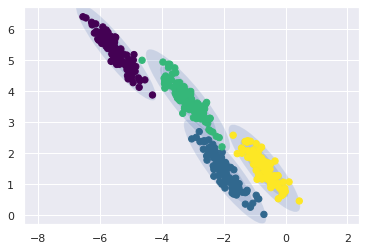

In [12]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

> This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

这样能清楚看出GMM能解决前面说道的k均值的两大问题。

### Choosing the covariance type

### 选择协方差的类型

> If you look at the details of the preceding fits, you will see that the ``covariance_type`` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is ``covariance_type="diag"``, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

如果你仔细观察刚才的例子，就会发现`covariance_type`设置是不一样的。这个超参数控制着聚类形状的自由度；对于每个不同的问题来说，小心的设置这个参数值是非常重要的。`covariance_type`的默认值是`'diag'`，这表示聚类形状的每个维度尺寸都可以独立的取值，结果就是聚类的形状是沿着坐标轴伸展的椭圆形。还有一个更简单和快速的模型是`covariance_type="spherical"`，这样产生的结果是聚类的形状是一个圆形，在每个坐标轴上的尺寸都是相等的，因此它的效果与k均值相似，虽然两者有一定差别。还有一个更复杂和计算量大的模型（尤其是当数据的维度增加时）是`covariance_type="full"`，产生的结果是每个聚类都是一个任意方向伸展的椭圆，其中每个维度的尺寸都是独立取值的。

> We can see a visual representation of these three choices for a single cluster within the following figure:

下面的图中我们可以看到三种不同取值的区别：

![(Covariance Type)](figures/05.12-covariance-type.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Covariance-Type)

## GMM as *Density Estimation*

## 使用高斯混合模型作为*密度估计*

> Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

虽然GMM经常被归为聚类算法，但它本质是一个*密度估计*算法。这就是说，GMM在一些数据上拟合的结果在技术上来说不是聚合模型，而是一个生成概率模型，用来描述数据的分布。

> As an example, consider some data generated from Scikit-Learn's ``make_moons`` function, which we saw in [In Depth: K-Means Clustering](05.11-K-Means.ipynb):

下面使用在[深入：K均值聚类](05.11-K-Means.ipynb)一节中使用Scikit-Learn的`make_moons`函数生成的数据作为例子：

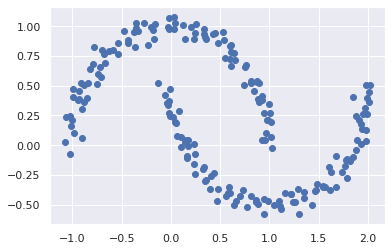

In [13]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

> If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

如果我们尝试使用两个成分的GMM模型来拟合它时，产生的结果并没有意义：

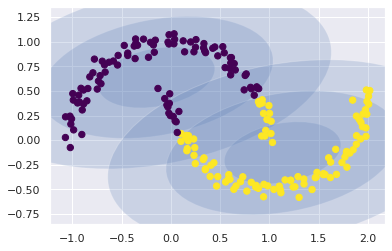

In [14]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

> But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

但是如果使用更多的聚类数量并忽略聚类产生的标签的话，我们会得到一个更接近输入数据的模型结果：

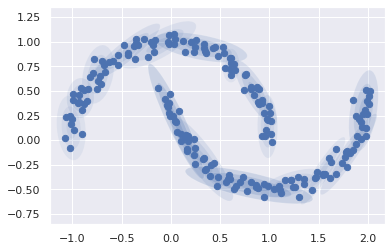

In [15]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

> Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

上面的例子并不是将数据分为16个高斯混合模型聚类，而是产生了数据的分布模型。这就是分布生成模型，代表着GMM为我们提供了按照数据分布情况产生新的随机数据的方法。例如，下面是使用这个GMM模型产生400个新数据点的方法，它们将符合原始数据的分布情况：

译者注：GaussianMixture的sample方法签名和返回值都发生了变化，以下代码做了相应调整。

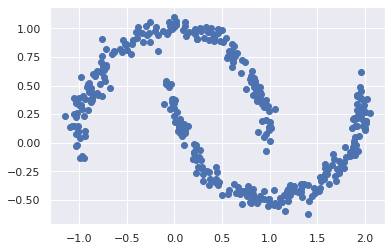

In [16]:
Xnew, _ = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

> GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

GMM可以作为产生任意多维度分布数据的生成模型的方便工具。

### How many components?

### 需要多少成分？

> The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

GMM是一个生成模型的事实提供给我们一个自然的方式，来获得对于给定的数据集所需的成分数量。一个生成模型实际上是数据集的概率分布，因此我们可以在模型下计算数据的*似然度*，然后使用交叉验证来避免过拟合。另外两个解决过拟合的方法是使用分析标准来调整模型的*似然度*，例如[赤池信息量准则(AIC)](https://zh.wikipedia.org/wiki/%E8%B5%A4%E6%B1%A0%E4%BF%A1%E6%81%AF%E9%87%8F%E5%87%86%E5%88%99)和[贝叶斯信息量准则(BIC)](https://zh.wikipedia.org/wiki/%E8%B4%9D%E5%8F%B6%E6%96%AF%E4%BF%A1%E6%81%AF%E9%87%8F%E5%87%86%E5%88%99)。Scikit-Learn的`GaussianMixture`评估器包含了內建的方法能够计算上述准则，非常方便使用。

> Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

让我们看看在上面的数据集中，AIC和BIC随着GMM成分数量变化的情况：

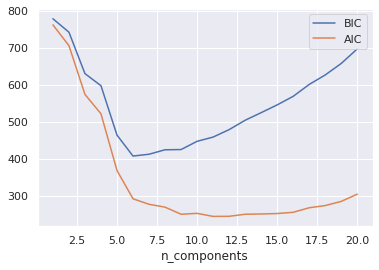

In [17]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

> The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

GMM成分数量的最优选择是能最小化AIC和BIC的值，取决于我们希望应用哪种近似。上图中AIC告诉我们16个成分也许太多了：区间8-12的成分值会是更好的选择。在通常的情况下，BIC标准会推荐一个更简单的模型。

> Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

注意很重要的一点：这个成分数量的选择只是衡量GMM作为*密度估计模型*的表现，不是它作为*聚类算法*的表现。作者更鼓励你将GMM主要看成是密度估计，仅在简单数据集中才放心的将它用作聚类算法。

## Example: GMM for Generating New Data

## 例子：用GMM来生成新数据

> We just saw a simple example of using GMM as a generative model of data in order to create new samples from the distribution defined by the input data.
Here we will run with this idea and generate *new handwritten digits* from the standard digits corpus that we have used before.

我们刚才看到了一个用GMM作为生成模型的简单例子，模型能从输入数据的分布中产生新的样本。下面我们将使用这个思想来生成*新的手写数字*，使用的输入训练数据集是我们前面很熟悉的手写数字数据集。

> To start with, let's load the digits data using Scikit-Learn's data tools:

首先使用Scikit-Learn的数据工具载入手写数字数据集：

In [18]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

> Next let's plot the first 100 of these to recall exactly what we're looking at:

然后查看前面的100个样本：

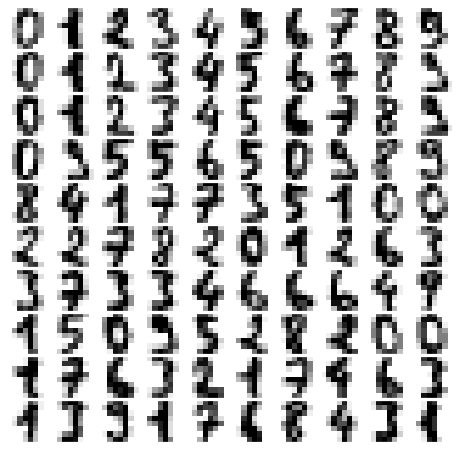

In [19]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

> We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more.
GMMs can have difficulty converging in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data.
Here we will use a straightforward PCA, asking it to preserve 99% of the variance in the projected data:

数据集中有接近1800个数字，每个数字都有64个维度，我们来构建一个GMM模型并且生成更多的手写数字。GMM在如此高维度空间中可能很难收敛，因此首先我们使用一个可能的降维算法来降低数据集的维度。下面我们直接使用PCA，要求它在降维后保留99%的可解释方差：

In [20]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

> The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss.
Given this projected data, let's use the AIC to get a gauge for the number of GMM components we should use:

结果有42个维度，接近降低了1/3的维度，但是基本上没有信息的损失。在这个数据上，我们使用AIC来测算我们在GMM模型中需要使用的成分数量：

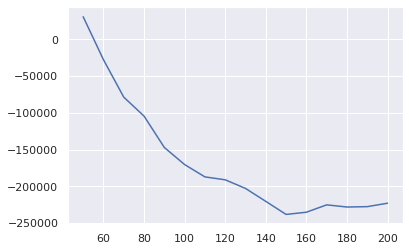

In [21]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

> It appears that around 110 components minimizes the AIC; we will use this model.
Let's quickly fit this to the data and confirm that it has converged:

看起来在150附近AIC具有最小值；让我们使用这个成分之来拟合数据，并查看模型收敛状态：

译者注：译者运行结果为150个成分最优，因此下面代码也做了修改。

In [22]:
gmm = GaussianMixture(150, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


> Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

现在们可以使用这个GMM作为生成模型，在这个41维空间中创建100个新的数据点：

In [23]:
data_new, _ = gmm.sample(100)
data_new.shape

(100, 41)

> Finally, we can use the inverse transform of the PCA object to construct the new digits:

最后，我们使用PCA的逆向转换重新构建这100个手写数字：

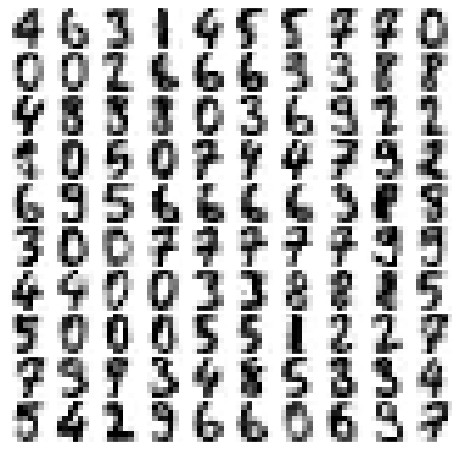

In [24]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

> The results for the most part look like plausible digits from the dataset!

我们看到结果中大多数的数字都很符合数据集的情况。

> Consider what we've done here: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits" which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model.
Such a generative model of digits can prove very useful as a component of a Bayesian generative classifier, as we shall see in the next section.

再次考虑这个过程：给定一些手写数字的样本，根据数据的分布构建了模型，然后我们使用这个模型生成全新的数字样本：这些“手写数字”并不是在原始数据集中的，而是通过捕捉到输入数据的主要特征的混合模型生成的。这样的数字生成模型作为贝叶斯生成分类器的组成部分会非常有用，我们将会在下一节看到。

<!--NAVIGATION-->
< [深入：k-均值聚类](05.11-K-Means.ipynb) | [目录](Index.ipynb) | [深入：核密度估计](05.13-Kernel-Density-Estimation.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
